In [1]:
# Importing libraries

import re
import pandas as pd
import numpy as np
import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential

#### Dataset Loading

In [2]:
# reading data

data = pd.read_csv(r'C:\Data Science\AI\NLP\Lecture Notebooks\googleplaystore_user_reviews.csv')

data.head()

,App,Translated_Review,Sentiment
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive
2,10 Best Foods for You,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive
4,10 Best Foods for You,Best idea us,Positive


In [3]:
# drop unnecessary columns and rename cols

data.drop(['App'], axis=1, inplace=True)

data.columns = ['review', 'sentiment']

data.head()

,review,sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
2,NaN,NaN
3,Works great especially going grocery store,Positive
4,Best idea us,Positive


#### EDA

In [4]:
# check data shape

data.shape

(64295, 2)

In [5]:
# check missing values

data.isna().sum()

review       26868
sentiment    26863
dtype: int64

In [6]:
# dropping null values

data.dropna(inplace=True)

<Axes: xlabel='sentiment'>

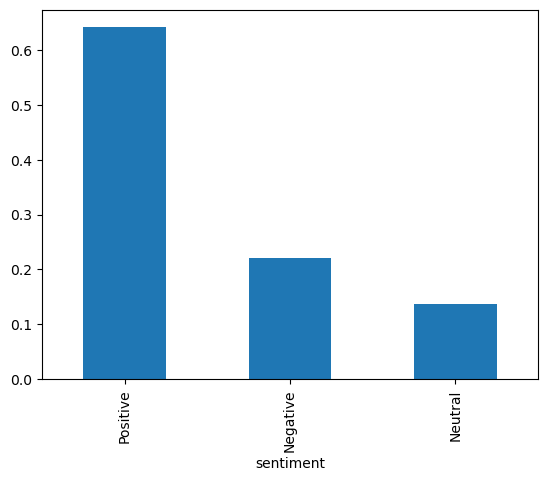

In [7]:
# check target balance

data['sentiment'].value_counts(normalize = True).plot.bar()

#### Text Preprocessing pipeline

In [8]:
# text preprocessing

def preprocess_pipeline(text_data):
    # create a list text

    lemmatizer = WordNetLemmatizer()

    if str(type(text_data)) != "<class 'str'>":
        text = list(text_data)
        
        # preprocessing loop

        corpus = []

        for i in range(len(text)):

            r = re.sub('[^a-zA-Z]', ' ', text[i])

            r = r.lower()

            r = r.split()

            r = [word for word in r if word not in stopwords.words('english')]

            r = [lemmatizer.lemmatize(word) for word in r]

            r = ' '.join(r)

            corpus.append(r)

        return corpus
    
    else:
        
        r = re.sub('[^a-zA-Z]', ' ', text_data)

        r = r.lower()

        r = r.split()

        r = [word for word in r if word not in stopwords.words('english')]

        r = [lemmatizer.lemmatize(word) for word in r]

        r = ' '.join(r)

        return r

In [9]:
#assign corpus to data['text']
preprocessed_text = preprocess_pipeline(data['review'])

In [10]:
data['review'] = preprocessed_text

data.head()

,review,sentiment
0,like eat delicious food cooking food case best...,Positive
1,help eating healthy exercise regular basis,Positive
3,work great especially going grocery store,Positive
4,best idea u,Positive
5,best way,Positive


In [15]:
data.to_csv('sentiments_cleaned_data.csv', index=False)

In [12]:
data.head()

,review,sentiment
0,like eat delicious food cooking food case best...,Positive
1,help eating healthy exercise regular basis,Positive
3,work great especially going grocery store,Positive
4,best idea u,Positive
5,best way,Positive


#### Train-Test split

In [57]:
# Create Feature and Label sets

X = data['review']

y = data['sentiment']


# train test split (66% train - 33% test)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print('Training Data :', X_train.shape)

print('Testing Data : ', X_test.shape)

Training Data : (26198,)
Testing Data :  (11229,)


In [58]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

#### Feature Extraction

In [19]:
# Installing gensim

# %pip install gensim

In [28]:
# Pre trained Word2Vec model

from gensim.models import Word2Vec,KeyedVectors

##### Pre-trained embeddings

In [29]:
embed_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [30]:
# Generating embeddings

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [embed_model[word] for word in words if word in embed_model]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_embed_trained = np.array([vectorize(sentence) for sentence in X_train])
X_test_embed_trained = np.array([vectorize(sentence) for sentence in X_test])

#### Model Training and evaluation

#### Using pre-trained embeddings

In [31]:
model = Sequential()
model.add(Dense(128,input_shape = (300,), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               38528     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [32]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [34]:
model.fit(X_train_embed_trained, np.array(y_train, dtype='float'), epochs=20, validation_split=0.2)

Epoch 1/20
655/655 [==============================] - 6s 4ms/step - loss: 0.8068 - accuracy: 0.6563 - val_loss: 0.5654 - val_accuracy: 0.7714
Epoch 2/20
655/655 [==============================] - 3s 5ms/step - loss: 0.5806 - accuracy: 0.7607 - val_loss: 0.4763 - val_accuracy: 0.8080
Epoch 3/20
655/655 [==============================] - 3s 5ms/step - loss: 0.5300 - accuracy: 0.7842 - val_loss: 0.4608 - val_accuracy: 0.8128
Epoch 4/20
655/655 [==============================] - 3s 4ms/step - loss: 0.5107 - accuracy: 0.7894 - val_loss: 0.4499 - val_accuracy: 0.8218
Epoch 5/20
655/655 [==============================] - 3s 5ms/step - loss: 0.4971 - accuracy: 0.7967 - val_loss: 0.4529 - val_accuracy: 0.8204
Epoch 6/20
655/655 [==============================] - 3s 5ms/step - loss: 0.4736 - accuracy: 0.8097 - val_loss: 0.4470 - val_accuracy: 0.8179
Epoch 7/20
655/655 [==============================] - 3s 5ms/step - loss: 0.4642 - accuracy: 0.8077 - val_loss: 0.4470 - val_accuracy: 0.8155
Epoch 

In [37]:
probabilities = model.predict(X_test_embed_trained)

probabilities

351/351 [==============================] - 1s 2ms/step


array([[1.14946235e-02, 3.66241235e-04, 9.88139212e-01],
       [1.70086846e-02, 2.44292052e-04, 9.82747078e-01],
       [2.02307820e-01, 6.12016395e-03, 7.91572034e-01],
       ...,
       [5.52537739e-01, 3.39584053e-02, 4.13503855e-01],
       [5.79106389e-03, 1.84948833e-04, 9.94023979e-01],
       [7.59959102e-01, 2.17858050e-02, 2.18255088e-01]], dtype=float32)

In [38]:
predictions = np.argmax(probabilities, axis=1)

predictions

array([2, 2, 2, ..., 0, 2, 0], dtype=int64)

In [39]:
# confusion matrix
from sklearn import metrics

df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions),index=['Negative','Neutral','Positive'], columns=['Negative','Neutral','Positive'])

df

,Negative,Neutral,Positive
Negative,1377,90,1014
Neutral,92,1033,423
Positive,226,116,6858


In [41]:
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.82
Recall: 0.83


#### Using Embeddings in Keras library

In [59]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [60]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

15374

In [61]:
# Pad the sequences to a fixed length
max_length = 300
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [62]:
# Define the ANN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 100)          1537400   
                                                                 
 flatten_2 (Flatten)         (None, 30000)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               3840128   
                                                                 
 batch_normalization_15 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                      

In [63]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)

Epoch 1/10
574/574 [==============================] - 59s 97ms/step - loss: 0.8666 - accuracy: 0.6345 - val_loss: 0.8928 - val_accuracy: 0.5817
Epoch 2/10
574/574 [==============================] - 55s 95ms/step - loss: 0.5544 - accuracy: 0.7869 - val_loss: 1.6199 - val_accuracy: 0.4734
Epoch 3/10
574/574 [==============================] - 55s 96ms/step - loss: 0.3922 - accuracy: 0.8653 - val_loss: 0.9899 - val_accuracy: 0.6525
Epoch 4/10
574/574 [==============================] - 55s 95ms/step - loss: 0.3099 - accuracy: 0.8994 - val_loss: 0.4782 - val_accuracy: 0.8308
Epoch 5/10
574/574 [==============================] - 55s 96ms/step - loss: 0.2392 - accuracy: 0.9267 - val_loss: 0.5077 - val_accuracy: 0.8146
Epoch 6/10
574/574 [==============================] - 55s 96ms/step - loss: 0.2127 - accuracy: 0.9375 - val_loss: 1.2501 - val_accuracy: 0.7055
Epoch 7/10
574/574 [==============================] - 55s 96ms/step - loss: 0.1781 - accuracy: 0.9473 - val_loss: 0.4756 - val_accuracy:

In [49]:
probabilities = model.predict(X_test)

probabilities

351/351 [==============================] - 9s 23ms/step


array([[1.1816932e-03, 1.9971980e-04, 9.9861860e-01],
       [5.1033153e-04, 4.9760911e-05, 9.9943990e-01],
       [4.6026930e-01, 2.4515316e-03, 5.3727919e-01],
       ...,
       [9.9683774e-01, 3.6820775e-04, 2.7939652e-03],
       [2.1245570e-03, 2.1115759e-04, 9.9766433e-01],
       [9.5834899e-01, 1.7499614e-03, 3.9900973e-02]], dtype=float32)

In [50]:
predictions = np.argmax(probabilities, axis=1)

predictions

array([2, 2, 2, ..., 0, 2, 0], dtype=int64)

In [51]:
# confusion matrix
from sklearn import metrics

df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions),index=['Negative','Neutral','Positive'], columns=['Negative','Neutral','Positive'])

df

,Negative,Neutral,Positive
Negative,1960,0,521
Neutral,830,10,708
Positive,309,0,6891


In [52]:
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.82
Recall: 0.79


In [55]:
model.evaluate(X_test, y_test, verbose=1)

351/351 [==============================] - 7s 19ms/step - loss: 0.9889 - accuracy: 0.7891


[0.9888536930084229, 0.7891174554824829]